# TalkingData AdTracking Fraud Detection Challenge
# Can you detect fraudulent click traffic for mobile app ads?
# https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection

**This notebook is inspired by an exercise in the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course**  
**It is also inspired by David Patton's notebook at [this link ](https://www.kaggle.com/dcpatton/td-fraud-detector-nn)**  
**You can reference the tutorial at [this link](https://www.kaggle.com/matleonard/baseline-model)**  
**You can reference my notebook at [this link](https://www.kaggle.com/georgezoto/feature-engineering-baseline-model)**  

---


# Introduction

In the exercise, you will work with data from the TalkingData AdTracking competition.  The goal of the competition is to predict if a user will download an app after clicking through an ad. 

<center><a href="https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection"><img src="https://i.imgur.com/srKxEkD.png" width=600px></a></center>

For this course you will use a small sample of the data, dropping 99% of negative records (where the app wasn't downloaded) to make the target more balanced.

After building a baseline model, you'll be able to see how your feature engineering and selection efforts improve the model's performance.

## Notes on strategy from 1st place winners
https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56475
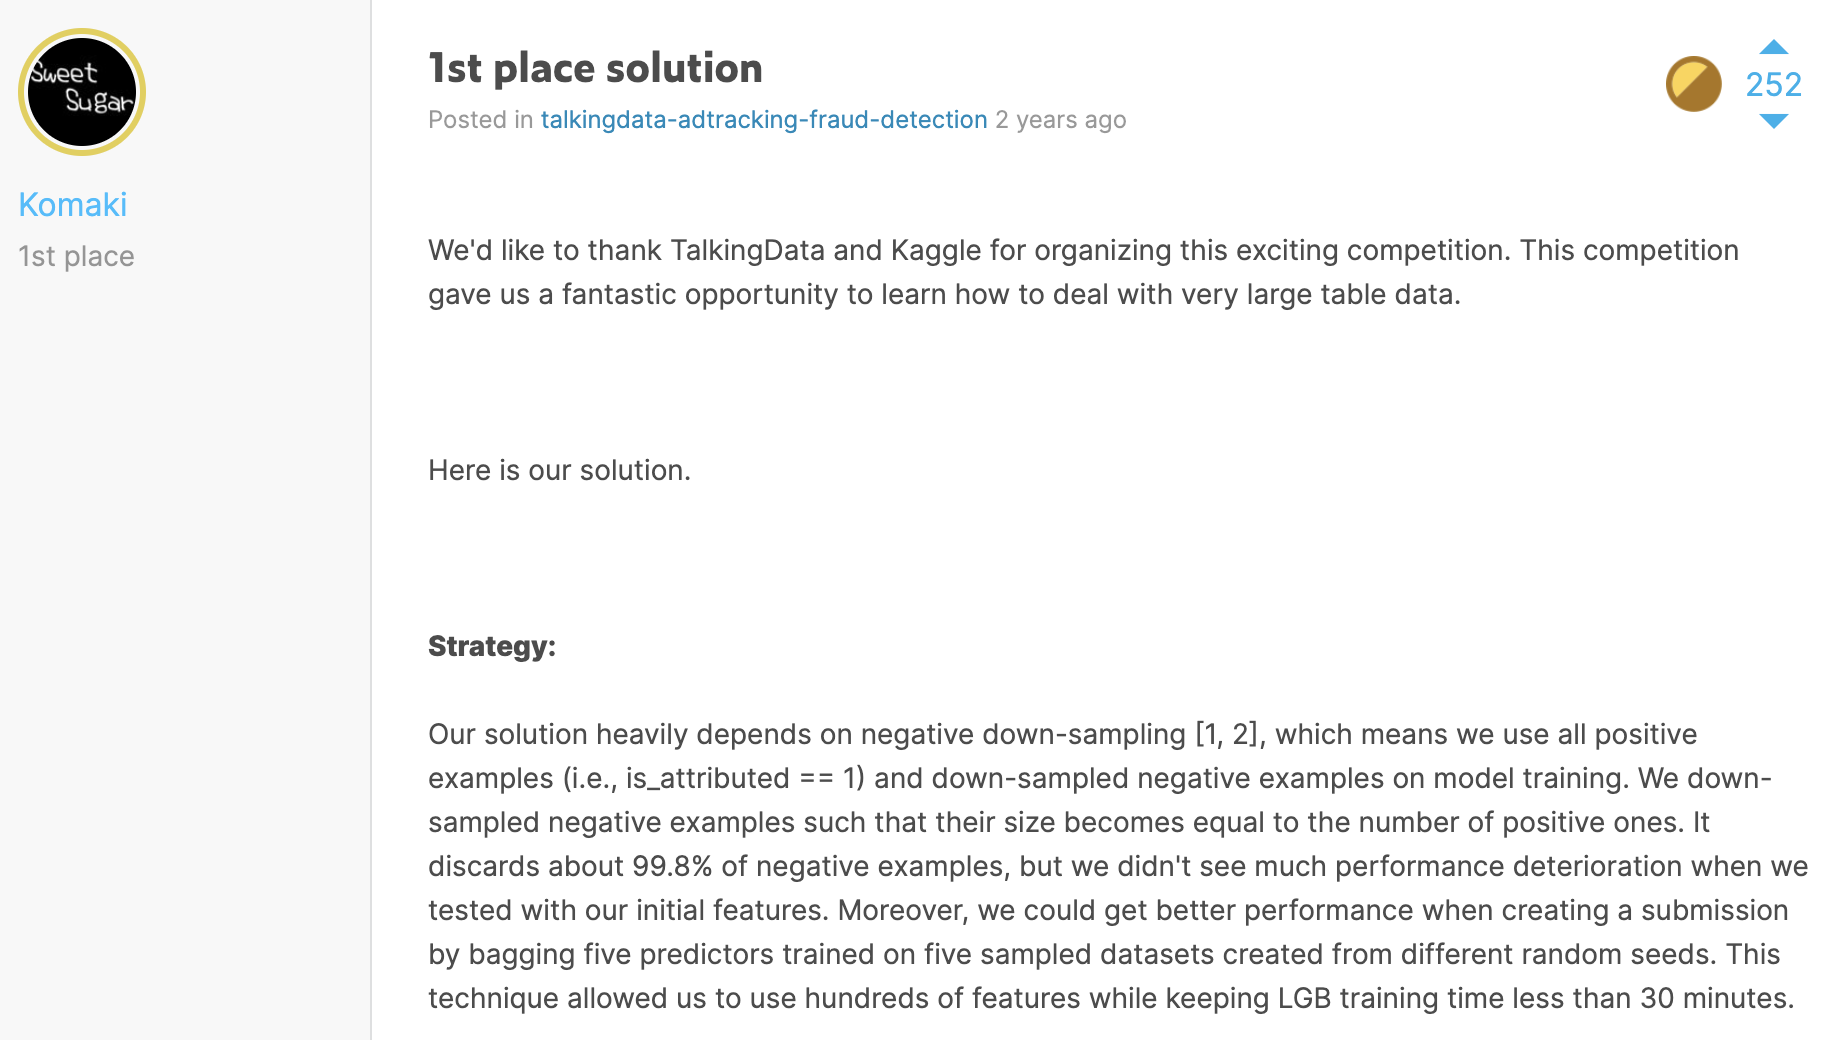

## Baseline Model

The first thing you'll do is construct a baseline model. We'll begin by looking at the data.

Data fields  
Each row of the training data contains a click record, with the following features.  

- ip: ip address of click.
- app: app id for marketing.
- device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- os: os version id of user mobile phone
- channel: channel id of mobile ad publisher
- click_time: timestamp of click (UTC)
- attributed_time: if user download the app for after clicking an ad, this is the time of the app download
- is_attributed: the target that is to be predicted, indicating the app was downloaded  

Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:
- click_id: reference for making predictions
- is_attributed: not included

In [ ]:
import dask
import dask.dataframe as dd
import numpy as np
import pandas as pd
import os
import time

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## ⚠️ Your notebook tried to allocate more memory than is available. It has restarted. ⚠️

## Use smaller storage dtypes

In [ ]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'object',
        'device'        : 'object',
        'os'            : 'object',
        'channel'       : 'object',
        'click_time'    : 'object',
        'is_attributed' : 'uint8',
        }

In [ ]:
#Sample data - (100000, 8)
#click_data = pd.read_csv('../input/talkingdata-adtracking-fraud-detection/train_sample.csv', parse_dates=['click_time'])

#Full data - No idea how large it is, this notebook can not handle its size in RAM

#Read only first limit rows
#limit = 20_000_000

#Read only these columns - skip attributed_time 
usecols = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']

## Competition data

In [ ]:
competition_data = dd.read_csv('../input/talkingdata-adtracking-fraud-detection/train.csv', 
                               dtype=dtypes,
                               #nrows=limit, #not supported by `dd.read_csv`
                               usecols=usecols, 
                               parse_dates=['click_time'])

In [ ]:
competition_data.info()

In [ ]:
competition_data_postitive = competition_data[competition_data.is_attributed == 1] 

In [ ]:
start_time = time.time()
type(competition_data_postitive)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()
competition_data_postitive = competition_data_postitive.compute()
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print(type(competition_data_postitive), competition_data_postitive.shape)

In [ ]:
competition_data_postitive.sample(10)

In [ ]:
competition_data_negative = competition_data[competition_data.is_attributed == 0] 

In [ ]:
competition_data_negative = competition_data_negative.sample(frac=0.0025) #number

In [ ]:
start_time = time.time()
competition_data_negative = competition_data_negative.compute()
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
competition_data_negative.sample(10)

In [ ]:
train_competition_data = pd.concat([competition_data_postitive, competition_data_negative])

In [ ]:
train_competition_data.is_attributed.value_counts()

In [ ]:
train_competition_data.info()

### Competition submission step

In [ ]:
test_dtypes = {
        'click_id'      : 'uint32',
        'ip'            : 'uint32',
        'app'           : 'object',
        'device'        : 'object',
        'os'            : 'object',
        'channel'       : 'object',
        'click_time'    : 'object'
        }

In [ ]:
usecols

In [ ]:
competition_test_data = dd.read_csv('../input/talkingdata-adtracking-fraud-detection/test.csv', 
                               dtype=test_dtypes,
                               #nrows=limit, #not supported by `dd.read_csv`
                               #usecols=usecols, #no columns needed to be skipped here
                               parse_dates=['click_time'])

In [ ]:
start_time = time.time()
competition_test_data = competition_test_data.compute()
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print(competition_test_data.shape)
competition_test_data.head()

## Feature Engineering 1 Construct features from timestamps

Notice that the `click_data` DataFrame has a `'click_time'` column with timestamp data.

Use this column to create features for the coresponding day, hour, minute and second. 

Store these as new integer columns `day`, `hour`, `minute`, and `second` in a new DataFrame `clicks`.

In [ ]:
# Add new columns for timestamp features day, hour, minute, and second
clicks = train_competition_data.copy()
clicks['day'] = clicks['click_time'].dt.day.astype('uint8')
# Fill in the rest
clicks['hour'] = clicks['click_time'].dt.hour.astype('uint8')
clicks['minute'] = clicks['click_time'].dt.minute.astype('uint8')
clicks['second'] = clicks['click_time'].dt.second.astype('uint8')

In [ ]:
clicks.head()

### Competition submission step

In [ ]:
# Add new columns for timestamp features day, hour, minute, and second
competition_test_data = competition_test_data.copy()
competition_test_data['day'] = competition_test_data['click_time'].dt.day.astype('uint8')
# Fill in the rest
competition_test_data['hour'] = competition_test_data['click_time'].dt.hour.astype('uint8')
competition_test_data['minute'] = competition_test_data['click_time'].dt.minute.astype('uint8')
competition_test_data['second'] = competition_test_data['click_time'].dt.second.astype('uint8')

In [ ]:
competition_test_data.head()

### Question ??? 

class sklearn.preprocessing.LabelEncoder[source]
Encode target labels with value between 0 and n_classes-1.

This transformer should be used to encode **target values**, i.e. y, and not the input X.

## Feature Engineering 2 Label Encoding
For each of the categorical features `['ip', 'app', 'device', 'os', 'channel']`, use scikit-learn's `LabelEncoder` to create new features in the `clicks` DataFrame. The new column names should be the original column name with `'_labels'` appended, like `ip_labels`.

## ⚠️ ValueError: y contains previously unseen labels: [0, 1, 2,... ⚠️

## 😀 Not the best solution to ValueError: y contains previously unseen labels: [0, 1, 2,... 😀
## unknown_value = -1
## ⚠️ Make sure this is int (as other labels) or you will not be able to predict in the end ⚠️
## https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values

## Workaround #2 potential data leakage???
## http://kagglesolutions.com/r/feature-engineering--label-encoding
## To resolve this issue we will first concatenate X_train and X_test together and then perform label encoding. You can have everything in a loop for all of your categorical features

```
X_train = pd.DataFrame({'x1': np.random.random(5), 'x2': ['cat', 'cat', 'dog', 'cat', 'dog']})
X_test = pd.DataFrame({'x1': np.random.random(5), 'x2': ['cat', 'cat', 'dog', 'rat', 'dog']})

categorical_features = ['x2']

# make an encoder object
encoder = LabelEncoder()

# fit and transform feature x2
for col in categorical_features:
    encoder.fit(pd.concat([X_train[col], X_test[col]], axis=0, sort=False))
    X_train[col] = encoder.transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])
    
print(X_train.head(), '\n')
print(X_test.head(), '\n')
```

In [ ]:
# Not the best solution to ValueError: y contains previously unseen labels: [0, 1, 2,...
unknown_value = -1 #Make sure this is int (as other labels) or you will not be able to predict in the end ⚠️

from sklearn import preprocessing

cat_features = ['ip', 'app', 'device', 'os', 'channel']
#cat_features = ['ip']

#encoder = preprocessing.LabelEncoder() - Incorrect, we need a label encoder for each feature
# Create new columns in clicks using preprocessing.LabelEncoder()

for feature in cat_features:
    start_time = time.time()
    print(feature)
    
    #New encoder for each feature
    encoder = preprocessing.LabelEncoder()
    
    #Fit on all possible values of this feature
    encoder.fit(clicks[feature])
    
    #Create LabelEncoder of input to output
    le_dict = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    
    #Encode unseen values to the unknown_value label
    encoded = clicks[feature].apply(lambda x: le_dict.get(x, unknown_value))
    clicks[feature+'_labels'] = encoded
    
    #Competition submission
    competition_encoded = competition_test_data[feature].apply(lambda x: le_dict.get(x, unknown_value))
    #ValueError: y contains previously unseen labels: [0, 2, 3, 4, 5,
    competition_test_data[feature+'_labels'] = competition_encoded
    
    print("--- %s seconds ---" % (time.time() - start_time))    

In [ ]:
clicks.head()

In [ ]:
competition_test_data.head(20)

## dask_ml.preprocessing.LabelEncoder
https://ml.dask.org/modules/generated/dask_ml.preprocessing.LabelEncoder.html

In [ ]:
#ip
#--- 96.38041996955872 seconds ---
dask_ml_preprocessing = """
start_time = time.time()

# Not the best solution to ValueError: y contains previously unseen labels: [0, 1, 2,...
unknown_value = -1 #Make sure this is int (as other labels) or you will not be able to predict in the end ⚠️

#from sklearn import preprocessing
from dask_ml import preprocessing #Dask preprocessing

#cat_features = ['ip', 'app', 'device', 'os', 'channel']
cat_features = ['ip']

#encoder = preprocessing.LabelEncoder() - Incorrect, we need a label encoder for each feature
# Create new columns in clicks using preprocessing.LabelEncoder()

for feature in cat_features:
    print(feature)
    
    #New encoder for each feature
    encoder = preprocessing.LabelEncoder(use_categorical=False) #Dask Specify use_categorical=False to recover the scikit-learn behavior.
    
    #Fit on all possible values of this feature
    encoder.fit(clicks[feature])
    
    #Create LabelEncoder of input to output
    le_dict = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    
    #Encode unseen values to the unknown_value label
    encoded = clicks[feature].apply(lambda x: le_dict.get(x, unknown_value))
    clicks[feature+'_labels'] = encoded
    
    #Competition submission
    competition_encoded = competition_test_data[feature].apply(lambda x: le_dict.get(x, unknown_value))
    #ValueError: y contains previously unseen labels: [0, 2, 3, 4, 5,
    competition_test_data[feature+'_labels'] = competition_encoded
    
print("--- %s seconds ---" % (time.time() - start_time))    
"""

## How many unknown_value did we get in the test dataset?

In [ ]:
train_ip_labels_unknowns = sum(clicks['ip_labels'] == unknown_value)
train_ip_labels_unknowns

In [ ]:
compet_test_ip_labels_unknowns = sum(competition_test_data['ip_labels'] == unknown_value)
compet_test_ip_labels_unknowns

In [ ]:
my_own_metrics={'clicks': clicks.shape[0], #min(limit, clicks.shape[0]),
                'competition_test_data':competition_test_data.shape[0],
                'train ip_labels unknowns': train_ip_labels_unknowns,
                'compet_test ip_labels unknowns':compet_test_ip_labels_unknowns,
                'compet_test ip_labels unknowns %': round(100*compet_test_ip_labels_unknowns/competition_test_data.shape[0],2)}
my_own_metrics

In [ ]:
clicks.shape

In [ ]:
competition_test_data.shape

## Feature Enginering 3 Add interactions
See also: https://www.kaggle.com/georgezoto/talkingdata-adtracking-comp-feature-generation

In [ ]:
import itertools

cat_features = ['ip', 'app', 'device', 'os', 'channel']
interactions = pd.DataFrame(index=clicks.index)

# Iterate through each pair of features, combine them into interaction features
for interaction_feature_tuple in itertools.combinations(cat_features,2):
    #New feature name as concatination of 2 categorical features
    interaction_feature  = '_'.join(list(interaction_feature_tuple))
    print(interaction_feature_tuple, interaction_feature)
    
    #New interaction as concatination of the values of each combination of cateforical features
    interactions_values = clicks[interaction_feature_tuple[0]].astype(str) + '_' + clicks[interaction_feature_tuple[1]].astype(str)
    
    #New label encoder for each interaction_feature 
    label_enc = preprocessing.LabelEncoder()
    #interactions = interactions.assign(interaction_feature=label_enc.fit_transform(interactions_values)) ??? uses the string interaction_feature as the column name ???
    #interactions[interaction_feature] = label_enc.fit_transform(interactions_values)                     #??? index values and how do they relate to the full dataset clicks ???

    #Fit on all possible values of this feature
    label_enc.fit(interactions_values)
    #Create LabelEncoder of input to output
    le_dict = dict(zip(label_enc.classes_, label_enc.transform(label_enc.classes_)))
    #Encode unseen values to the unknown_value label
    encoded = interactions_values.apply(lambda x: le_dict.get(x, unknown_value))
    clicks[interaction_feature] = encoded
    
    print('clicks.columns')
    print(clicks.columns)

    #Competition submission
    # Apply encoding to the competition test dataset
    comp_interactions_values = competition_test_data[interaction_feature_tuple[0]].astype(str) + '_' + competition_test_data[interaction_feature_tuple[1]].astype(str)
    #competition_test_data[interaction_feature] = label_enc.transform(comp_interactions_values)  #??? ValueError: y contains previously unseen labels: '119901_9' ???
    
    competition_encoded = comp_interactions_values.apply(lambda x: le_dict.get(x, unknown_value))
    competition_test_data[interaction_feature] = competition_encoded
    print('competition_test_data.columns')
    print(competition_test_data.columns)
    

In [ ]:
clicks.columns

In [ ]:
competition_test_data.columns

## Feature Enginering 4 Numerical Features Number of events in the past 6 hours

In [ ]:
def count_past_events_6h(series):
    new_series = pd.Series(index=series, data=series.index, name="count_6_hours").sort_index()
    #launched = pd.Series(data =ks.index, index=ks.launched, name="count_7_days").sort_index()
    #print(new_series.head())
    count_6_hours = new_series.rolling('6h').count() - 1
    return count_6_hours

In [ ]:
series = clicks[:100]['click_time']
series

In [ ]:
new_series = pd.Series(index=series, data=series.index, name="count_6_hours").sort_index()
new_series

In [ ]:
new_series.rolling('6h').count() - 1

In [ ]:
#clicks['count_past_events_6h'] = 
events_6h = count_past_events_6h(clicks[:100]['click_time'])
events_6h

In [ ]:
plt.plot(events_6h);

In [ ]:
#events_6h.index = events_6h.values
events_6h

In [ ]:
events_6h = events_6h.reindex(clicks[:100].index)
events_6h

In [ ]:
#competition_test_data['count_past_events_6h'] = competition_test_data['click_time'].apply(count_past_events_6h)

## Feature Enginering 5 Numerical Features Time since last event

In [ ]:
def time_diff_since_last_event(series):
    """Returns a series with the time since the last timestamp in seconds."""
    time_since_last_event = series.diff().dt.total_seconds()
    return time_since_last_event

In [ ]:
clicks['time_diff_since_last_event'] = clicks['click_time'].apply(time_diff_since_last_event)

In [ ]:
competition_test_data['time_diff_since_last_event'] = competition_test_data['click_time'].apply(time_diff_since_last_event)

## Feature Enginering 6 Numerical Features Number of previous app downloads

In [ ]:
def previous_attributions(series):
    """Returns a series with the number of times an app has been downloaded."""
    #print(series)
    #print(series.expanding(min_periods=2).sum())
    sums = series.expanding(min_periods=2).sum() - series
    return sums

In [ ]:
clicks['time_diff_since_last_event'] = clicks['click_time'].apply(time_diff_since_last_event)

# Machine Learning Model

## Train, validation, and test sets
With our baseline features ready, we need to split our data into training and validation sets. We should also hold out a test set to measure the final accuracy of the model.

### 4) Train/test splits with time series data
This is time series data. Are there any special considerations when creating train/test splits for time series? If so, what are they?

### Create train/validation/test splits

Here we'll create training, validation, and test splits. First, `clicks` DataFrame is sorted in order of increasing time. The first 80% of the rows are the train set, the next 10% are the validation set, and the last 10% are the test set.

In [ ]:
clicks.head()

In [ ]:
feature_cols = ['day', 'hour', 'minute', 'second', 
                'ip_labels', 'app_labels', 'device_labels',
                'os_labels', 'channel_labels']

valid_fraction = 0.1
clicks_srt = clicks.sort_values('click_time')
valid_rows = int(len(clicks_srt) * valid_fraction)
train = clicks_srt[:-valid_rows * 2]
# valid size == test size, last two sections of the data
valid = clicks_srt[-valid_rows * 2:-valid_rows]
test = clicks_srt[-valid_rows:]

In [ ]:
print(clicks.shape,'\n',train.shape,'\n',valid.shape,'\n',test.shape)

### Train with LightGBM

Now we can create LightGBM dataset objects for each of the smaller datasets and train the baseline model.

In [ ]:
import lightgbm as lgb

dtrain = lgb.Dataset(train[feature_cols], label=train['is_attributed'])
dvalid = lgb.Dataset(valid[feature_cols], label=valid['is_attributed'])
dtest = lgb.Dataset(test[feature_cols], label=test['is_attributed'])

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
#bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10)

In [ ]:
#type(bst) #lightgbm.basic.Booster

### ??? TypeError: booster must be dict or LGBMModel

- booster (dict or LGBMModel) – Dictionary returned from lightgbm.train() or LGBMModel instance.
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_metric.html

In [ ]:
#lgb.plot_metric(bst, metric=metrics.roc_auc_score, dataset_names=[dtrain, dvalid, dtest]) #??? TypeError: booster must be dict or LGBMModel
#, ax=None, xlim=None, ylim=None, title='Metric during training', xlabel='Iterations', ylabel='auto', figsize=None, dpi=None, grid=True)[source]

- evals_result (dict or None, optional (default=None)) –

This dictionary used to store all evaluation results of all the items in valid_sets.

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html

- validation_metrics inspired by:
https://github.com/Microsoft/LightGBM/blob/2e93cdab9eee02d4d7f5cb3b6b31128dec94e25e/examples/python-guide/plot_example.py

In [ ]:
#Record eval results for plotting
validation_metrics = {}  

bst = lgb.train(param, 
                dtrain, 
                num_round, 
                valid_sets=[dvalid],
                valid_names='Baseline Model',
                early_stopping_rounds=10,
                evals_result=validation_metrics,
                verbose_eval=10)

In [ ]:
validation_metrics

### Plot validation AUC during training

In [ ]:
ax = lgb.plot_metric(validation_metrics, metric='auc');
#plt.show();

## ML Explainability and taking a closer look at feature importance, individual trees
Inspired by: https://github.com/Microsoft/LightGBM/blob/2e93cdab9eee02d4d7f5cb3b6b31128dec94e25e/examples/python-guide/plot_example.py


In [ ]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=15)
plt.show()

In [ ]:
bst.num_trees()

In [ ]:
tree_index = 0
print('Plot '+str(tree_index)+'th tree...')  # one tree use categorical feature to split
ax = lgb.plot_tree(bst, tree_index=tree_index, figsize=(64, 36), show_info=['split_gain'])
plt.show()

## Evaluate the model
Finally, with the model trained, we evaluate its performance on the test set. 

In [ ]:
from sklearn import metrics

start_time = time.time()

ypred = bst.predict(test[feature_cols])
score = metrics.roc_auc_score(test['is_attributed'], ypred)
print(f"Test score: {score}")

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
my_own_metrics['test score'] = score

In [ ]:
my_own_metrics

In [ ]:
#plt.bar(my_own_metrics.keys(), my_own_metrics.values())

This will be our baseline score for the model. When we transform features, add new ones, or perform feature selection, we should be improving on this score. However, since this is the test set, we only want to look at it at the end of all our manipulations. At the very end of this course you'll look at the test score again to see if you improved on the baseline model.

# Keep Going
Now that you have a baseline model, you are ready to **[use categorical encoding techniques](https://www.kaggle.com/matleonard/categorical-encodings)** to improve it.

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/161443) to chat with other Learners.*

# Submit test predictions to TalkingData AdTracking Fraud Detection Challenge competition using the ***limited*** train.csv records from this notebook

In [ ]:
feature_cols + ['click_id']

In [ ]:
competition_test_data = competition_test_data[feature_cols + ['click_id']]

In [ ]:
competition_test_data.shape

In [ ]:
competition_test_data.head()

In [ ]:
test[feature_cols].head()

In [ ]:
start_time = time.time()
competition_predictions = bst.predict(competition_test_data[feature_cols])
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
type(competition_predictions)

In [ ]:
competition_predictions

In [ ]:
competition_predictions_df = pd.DataFrame({'click_id': competition_test_data['click_id'],
                                           'is_attributed': competition_predictions})
competition_predictions_df

In [ ]:
#Takes a long time
#competition_predictions_df['click_id'] = competition_test_data['click_id']
#competition_predictions_df = competition_predictions_df[['click_id', 'is_attributed']]
#competition_predictions_df

In [ ]:
#competition_predictions_df['is_attributed'].value_counts().sort_index()

In [ ]:
pd.cut(competition_predictions_df['is_attributed'], bins=10).value_counts().sort_index()

In [ ]:
pd.cut(competition_predictions_df['is_attributed'], bins=10).value_counts().sort_index().plot(kind='bar', rot=45);

In [ ]:
#competition_predictions_df['is_attributed'].value_counts().sort_index().plot(kind='bar');

In [ ]:
#sum(competition_predictions_df['is_attributed'] <= 0.5)/competition_predictions_df.shape[0]

In [ ]:
#sum(competition_predictions_df['is_attributed'] > 0.5)/competition_predictions_df.shape[0]

In [ ]:
competition_predictions_df.to_csv('submission.csv', index=False)

In [ ]:
my_own_metrics['private score'] = 0
my_own_metrics['public score'] = 0
my_own_metrics

# Submit csv to competition
<center><a href="https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection"><img src="https://i.imgur.com/srKxEkD.png" width=400px></a></center>

# Deep Learning Model

## Data structure

In [ ]:
clicks.head()

In [ ]:
competition_test_data.head()

## Import TensorFlow libraries

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import random
seed = 51
tf.random.set_seed(seed)
random.seed(seed)

import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]

## Check if the dataset contains unknown values

In [ ]:
clicks.isna().sum()

In [ ]:
clicks.dtypes

## Split the data

In [ ]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(clicks, stratify=clicks['is_attributed'], test_size=0.2, random_state=seed)
train_dataset, validation_dataset = train_test_split(train_dataset, stratify=train_dataset['is_attributed'], test_size=0.2, random_state=seed)

print(train_dataset.shape, validation_dataset.shape, test_dataset.shape)
print(100*train_dataset.shape[0]/clicks.shape[0], 100*validation_dataset.shape[0]/clicks.shape[0], 100*test_dataset.shape[0]/clicks.shape[0])

## Inspect the data

In [ ]:
sns.pairplot(train_dataset[['day', 'hour', 'minute', 'second', 'ip_labels', 'app_labels', 'device_labels', 'os_labels', 'channel_labels', 'is_attributed']], height=3)

## Split features from labels

In [ ]:
train_labels = train_dataset.pop('is_attributed')
validation_labels = validation_dataset.pop('is_attributed')
test_labels = test_dataset.pop('is_attributed')

## Keep only numerical features after label encoding above

In [ ]:
feature_col = ['day', 'hour', 'minute', 'second', 'ip_labels', 'app_labels', 'device_labels', 'os_labels', 'channel_labels']

#Another way
#train_dataset.select_dtypes(exclude='object')

train_dataset = train_dataset[feature_col]
validation_dataset = validation_dataset[feature_col]
test_dataset = test_dataset[feature_col]

## Normalize the data ⚠️ WRONG ⚠️ You get good performance on training** and validation but very bad results on comp test data

In [ ]:
def norm_WRONG(df):
    return (df - df.mean()) / df.std()

#AUC is around 0.55 with no normalization
#normed_train_data = train_dataset
#normed_validation_data = validation_dataset
#normed_test_data = test_dataset

## Normalize the data

In [ ]:
def norm(df):
    return (df - train_dataset.mean()) / train_dataset.std()

In [ ]:
normed_train_data = norm(train_dataset)
normed_validation_data = norm(validation_dataset)
normed_test_data = norm(test_dataset)

In [ ]:
train_dataset.head()

In [ ]:
normed_train_data.head()

In [ ]:
train_dataset['day'].hist();

In [ ]:
normed_train_data['day'].hist();

## Useful custom methods

In [ ]:
def compute_metrics(y_true, y_pred):
    tp = tf.keras.metrics.TruePositives()
    tp.update_state(y_true, y_pred)
    tp = int(tp.result().numpy())
    fp = tf.keras.metrics.FalsePositives()
    fp.update_state(y_true, y_pred)
    fp = int(fp.result().numpy())
    tn = tf.keras.metrics.TrueNegatives()
    tn.update_state(y_true, y_pred)
    tn = int(tn.result().numpy())
    fn = tf.keras.metrics.FalseNegatives()
    fn.update_state(y_true, y_pred)
    fn = int(fn.result().numpy())
    return [tp, fn, fp, tn]

In [ ]:
def print_metrics(metrics):
    print('True Positives: ' + str(metrics[0]))
    print('True Negatives: ' + str(metrics[3]))
    print('False Positives: ' + str(metrics[2]))
    print('False Negatives: ' + str(metrics[1]))

In [ ]:
def plot_results(history):
    history = history.history

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='col', figsize=(20, 14))

    ax1.plot(history['loss'], label='Train loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend(loc='best')
    ax1.set_title('Loss')

    ax2.plot(history['auprc'], label='Train AUPRC')
    ax2.plot(history['val_auprc'], label='Validation AUPRC')
    ax2.legend(loc='best')
    ax2.set_title('AUPRC')
    
    
    ax3.plot(history['auroc'], label='Train AUROC')
    ax3.plot(history['val_auroc'], label='Validation AUROC')
    ax3.legend(loc='best')
    ax3.set_title('AUROC')

    plt.xlabel('Epochs')
    sns.despine()
    plt.show()

## The model
## Build the model

In [ ]:
train_dataset.dtypes

In [ ]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc'), 
                          tf.keras.metrics.AUC(curve='PR', name='auprc')])
    model.summary()

    return model

In [ ]:
model = build_model()

## Now try out the model. Take a batch of 10 examples from the training data and call model.predict on it.

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

## Train the model

In [ ]:
checkpoint_filepath = 'talkingdata-adtracking-dask-ml-dl-v11.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True, 
                                                      monitor='val_auprc', mode='max', save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auprc', patience=10, verbose=1, mode='max')

In [ ]:
EPOCHS = 100
BATCH_SIZE = 256

In [ ]:
tf.keras.backend.clear_session()

history_v11 = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, 
  validation_data = (normed_validation_data, validation_labels), 
  batch_size=BATCH_SIZE,
  verbose=2, 
  callbacks=[model_checkpoint, early_stopping]
  )

In [ ]:
plot_results(history_v11)

## Predict on a small portion of the training set a.k.a the test set

In [ ]:
y_pred = model.predict(normed_test_data)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(test_labels, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC

In [ ]:
TF_Model_metrics = compute_metrics(test_labels, y_pred)
print_metrics(TF_Model_metrics)

In [ ]:
#EPOCHS = 100
#BATCH_SIZE = 256
#0.90584815
#True Positives: 73230
#True Negatives: 362160
#False Positives: 6734
#False Negatives: 18139

#Model v12
#TF_Model_AUPRC 0.9084018 
#TF_Model_AUROC 0.9549123
#True Positives: 70773
#True Negatives: 363975
#False Positives: 4919
#False Negatives: 20596
    
#EPOCHS = 100
#BATCH_SIZE = 128
#0.89784527
#True Positives: 71936
#True Negatives: 362700
#False Positives: 6194
#False Negatives: 19433

In [ ]:
test_labels[:5]

In [ ]:
y_pred[:5]

## Model v12

In [ ]:
def build_model_v12():
    tf.keras.backend.clear_session()

    model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.BatchNormalization(),
    layers.Dropout(0.33), #Remove dropout or lower %
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.33),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.33),
    layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc'), 
                          tf.keras.metrics.AUC(curve='PR', name='auprc')])

    model.summary()

    return model

In [ ]:
model = build_model_v12()

In [ ]:
checkpoint_filepath = 'talkingdata-adtracking-dask-ml-dl-v12.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True, 
                                                      monitor='val_auprc', mode='max', save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auprc', patience=10, verbose=1, mode='max')

In [ ]:
EPOCHS = 100
BATCH_SIZE = 256

In [ ]:
tf.keras.backend.clear_session()

history_v12 = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, 
    validation_data = (normed_validation_data, validation_labels), 
    batch_size=BATCH_SIZE,
    verbose=2, 
    callbacks=[model_checkpoint, early_stopping]
  )

In [ ]:
plot_results(history_v12)

In [ ]:
y_pred = model.predict(normed_test_data)

auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(test_labels, y_pred)
TF_Model_AUPRC = auprc.result().numpy()

auroc = tf.keras.metrics.AUC(curve='ROC')
auroc.update_state(test_labels, y_pred)
TF_Model_AUROC = auroc.result().numpy()

print('TF_Model_AUPRC',TF_Model_AUPRC, '\nTF_Model_AUROC', TF_Model_AUROC)

In [ ]:
TF_Model_metrics = compute_metrics(test_labels, y_pred)
print_metrics(TF_Model_metrics)

## Competition data 

In [ ]:
feature_cols = ['day', 'hour', 'minute', 'second', 
                'ip_labels', 'app_labels', 'device_labels',
                'os_labels', 'channel_labels']

In [ ]:
test_dataset.head()

In [ ]:
normed_test_data.head()

In [ ]:
competition_test_data[feature_cols].head()

In [ ]:
competition_test_data[feature_cols].dtypes

In [ ]:
competition_test_data[feature_cols].isna().sum()

In [ ]:
col = 'day'
print(competition_test_data[col].mean(), competition_test_data[col].std())

In [ ]:
competition_test_data['day'].hist();

In [ ]:
norm_competition_test_data = norm(competition_test_data[feature_cols])

In [ ]:
norm_competition_test_data['click_id'] = competition_test_data['click_id']

In [ ]:
norm_competition_test_data.head()

## ⚠️ Your notebook tried to allocate more memory than is available. It has restarted. ⚠️

## ⚠️ Partition competition_test_data so it fits in memory ⚠️

In [ ]:
total = norm_competition_test_data.shape[0]
h = int(total/3)

competition_test_data_partition1 = norm_competition_test_data.iloc[0:h]
competition_test_data_partition2 = norm_competition_test_data.iloc[h:2*h]
competition_test_data_partition3 = norm_competition_test_data.iloc[2*h:]

print(competition_test_data.shape, 
      competition_test_data_partition1.shape, 
      competition_test_data_partition2.shape, 
      competition_test_data_partition3.shape)

In [ ]:
start_time = time.time()
competition_predictions_1 = model.predict(competition_test_data_partition1[feature_cols])
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
competition_predictions_1_df = pd.DataFrame(competition_predictions_1, columns=['is_attributed'])
pd.cut(competition_predictions_1_df['is_attributed'], bins=10).value_counts().sort_index()

In [ ]:
pd.cut(competition_predictions_1_df['is_attributed'], bins=10).value_counts().sort_index().plot(kind='bar', rot=45);

In [ ]:
start_time = time.time()
competition_predictions_2 = model.predict(competition_test_data_partition2[feature_cols])
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
competition_predictions_2_df = pd.DataFrame(competition_predictions_2, columns=['is_attributed'])
pd.cut(competition_predictions_2_df['is_attributed'], bins=10).value_counts().sort_index()

In [ ]:
pd.cut(competition_predictions_2_df['is_attributed'], bins=10).value_counts().sort_index().plot(kind='bar', rot=45);

In [ ]:
start_time = time.time()
competition_predictions_3 = model.predict(competition_test_data_partition3[feature_cols])
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
competition_predictions_3_df = pd.DataFrame(competition_predictions_3, columns=['is_attributed'])
pd.cut(competition_predictions_3_df['is_attributed'], bins=10).value_counts().sort_index()

In [ ]:
pd.cut(competition_predictions_3_df['is_attributed'], bins=10).value_counts().sort_index().plot(kind='bar', rot=45);

In [ ]:
competition_predictions = np.append(competition_predictions_1, competition_predictions_2)
competition_predictions = np.append(competition_predictions, competition_predictions_3)

In [ ]:
submission_df = pd.read_csv('/kaggle/input/talkingdata-adtracking-fraud-detection/sample_submission.csv')

In [ ]:
submission_df['is_attributed'] = competition_predictions

In [ ]:
submission_df.head()

In [ ]:
pd.cut(submission_df['is_attributed'], bins=10).value_counts().sort_index()

In [ ]:
pd.cut(submission_df['is_attributed'], bins=10).value_counts().sort_index().plot(kind='bar', rot=45);

In [ ]:
submission_df.to_csv('dl_v11_label_encoding_submission.csv', index=False)

# Submit csv to competition
<center><a href="https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection"><img src="https://i.imgur.com/srKxEkD.png" width=400px></a></center>